In [1]:
%cd ../..

/volatile/home/Zaccharie/workspace/understanding-unets


In [2]:
# # this just to make sure we are using only on CPU
# import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
%matplotlib nbagg
import os.path as op
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm_notebook

from fastmri_recon.config import *
from fastmri_recon.data.fastmri_tf_datasets import \
    train_masked_kspace_dataset_from_indexable
from fastmri_recon.helpers.nn_mri import tf_fastmri_format
from learning_wavelets.keras_utils.fourier import (
    tf_masked_shifted_normed_fft2d, tf_masked_shifted_normed_ifft2d,
    tf_shifted_normed_fft2d, tf_shifted_normed_ifft2d)
from learning_wavelets.models.ista import IstaLearnlet

In [4]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'

In [44]:
# paths
val_path = f'{FASTMRI_DATA_DIR}singlecoil_val/'

n_volumes_train = 973
af = 4
val_set = train_masked_kspace_dataset_from_indexable(
    val_path,
    AF=af,
    contrast=None,
    scale_factor=1e6,
)

Getting training files from /media/Zaccharie/UHRes/singlecoil_val/


In [45]:
learnlet_params = {
    'denoising_activation': 'dynamic_soft_thresholding',
    'learnlet_analysis_kwargs':{
        'n_tiling': 16, 
        'mixing_details': False,    
        'skip_connection': True,
        'kernel_size': 7,
    },
    'learnlet_synthesis_kwargs': {
        'res': True,
        'kernel_size': 9,
    },
    'threshold_kwargs':{
        'noise_std_norm': False,
        'alpha_init': 2.0,
    },
    'n_scales': 4,
    'n_reweights_learn': 1,
    'exact_reconstruction': True,
    'undecimated': True,
    'clip': False,
}

model = IstaLearnlet(
    n_iterations=5,
    forward_operator=tf_masked_shifted_normed_fft2d,
    adjoint_operator=tf_masked_shifted_normed_ifft2d,
    postprocess=tf_fastmri_format,
    fista_mode=True,
    **learnlet_params,
)
model([tf.zeros((1, 640, 320, 1), dtype=tf.complex64), tf.zeros((1, 640, 320), dtype=tf.complex64)])
model.load_weights(
    'checkpoints/fista_learnlet_fastmri_16_5_dynamic_soft_thresholding_1583847877-300.hdf5',
)

In [46]:
kspace_mask, image = next(iter(val_set))
res = model(kspace_mask)

<IPython.core.display.Javascript object>


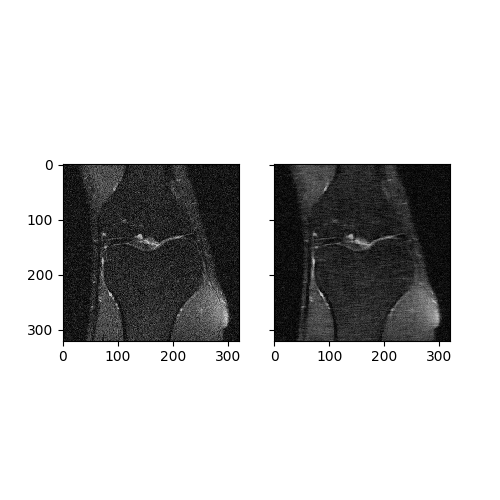

In [47]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(np.abs(image[15, ..., 0]), vmin=np.min(np.abs(image[15])), vmax=np.max(np.abs(image[15])))
axs[1].imshow(np.abs(res[15, ..., 0]), vmin=np.min(np.abs(image[15])), vmax=np.max(np.abs(image[15])))

In [40]:
[ib.alpha.numpy() for ib in model.ista_blocks]

[array([3.7774844], dtype=float32),
 array([0.8039643], dtype=float32),
 array([2.454377], dtype=float32),
 array([2.9134572], dtype=float32),
 array([1.1043086], dtype=float32)]

In [41]:
[ib.momentum.numpy() for ib in model.ista_blocks]

[array([1.2258856], dtype=float32),
 array([0.88153195], dtype=float32),
 array([0.7464578], dtype=float32),
 array([0.86974716], dtype=float32),
 array([0.64752364], dtype=float32)]

In [42]:
[l.alpha.numpy() for l in model.learnlet.threshold.thresholding_layers]

[array([2.4596734], dtype=float32),
 array([4.166243], dtype=float32),
 array([3.1170058], dtype=float32),
 array([1.6827879], dtype=float32)]

In [43]:
[l.alpha.numpy() for l in model.learnlet.threshold_wavelet.thresholding_layers]

[array([4.5638027], dtype=float32),
 array([3.5643647], dtype=float32),
 array([1.9737737], dtype=float32),
 array([1.2120405], dtype=float32)]